<a id='top'></a>

# Signal DSP using FFT and psd

This notebook will demonstrate some basic aspects related with digital signal processing using FFT and psd. It is mostly inspired by two LabVIEW white papers, [this one](http://www.ni.com/white-paper/4278/en/) and [this one](http://www.ni.com/white-paper/4541/en/). We will also take the oportunity to test different power spectrum estimation implementations from two common Python packages, [matplotlib.mlab](http://matplotlib.org/api/mlab_api.html) and [scipy.signal](https://scipy.github.io/devdocs/signal.html), following this [StackOverflow question](http://stackoverflow.com/questions/33286467/why-do-the-power-spectral-density-estimates-from-matplotlib-mlab-psd-and-scipy-s).

## Table of contents

[Preamble](#Preamble)

[Introduction](#Introduction)

[Digital signal](#Digital-signal)

[Fourier transform](#Fourier-transform)

[Power spectrum](#Power-spectrum)

[Matplotlib package](#Matplotlib-package)

[Conclusions](#Conclusions)

[Odds and ends](#Odds-and-ends)

## Preamble

The computational environment set up for this Python notebook includes numpy and scipy for the numerical simulations, matplotlib and pandas for the plots:

In [1]:
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version)
for package in (np, sp, mpl, pd):
    print('{:.<15}{}'.format(package.__name__, package.__version__))

3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
numpy..........1.11.2
scipy..........0.18.1
matplotlib.....1.5.3
pandas.........0.19.2+0.g825876c.dirty


Furthermore, we will need the following special functions:

In [2]:
from numpy.fft import fft, fftfreq, rfft, rfftfreq, fftshift
from scipy.signal import periodogram, welch
from matplotlib.mlab import rms_flat, psd, detrend_none, window_hanning

[Back to top](#top)

## Introduction

The power spectral density of a digital signal can be estimated in several different ways, namely using:

1. The [periodogram](https://en.wikipedia.org/wiki/Periodogram)
2. The [Bartlett's method](https://en.wikipedia.org/wiki/Bartlett%27s_method)
3. The [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)

We will illustrate each of them below. However, before that we will have to set up a digital signal.

[Back to top](#top)

## Digital signal

For the purpose of illustration, in this notebook we will use a digital signal composed of a small amplitude sine wave masked by a large amplitude random noise:

                    Max       Min      Mean       RMS
Random noise   0.499650 -0.497811  0.019811  0.294263
Sine wave      0.199999 -0.199999  0.001030  0.141467
Masked signal  0.674405 -0.685897  0.020841  0.324991


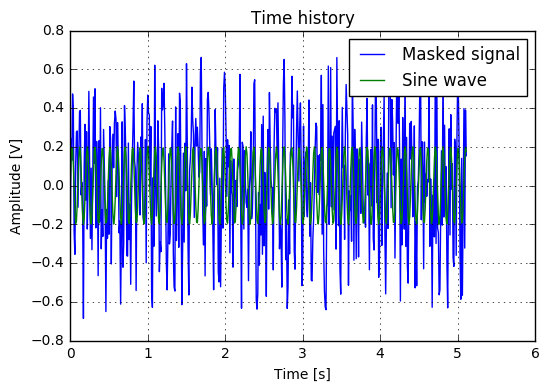

In [3]:
Ns = 512 # number of samples
np.random.seed(1234) # random seed (for reproducibility)
rn = np.random.random(Ns)-0.5 # zero mean random noise

Fs = 100 # sampling frequency
dt = 1./Fs # time discretisation
tt = np.arange(Ns)*dt # time sampling

A = 0.2 # sine wave amplitude
f = 10.24 # sine wave frequency
sw = A*np.sin(2*np.pi*f*tt) # sine wave

ms = sw+rn # masked signal

v = [(np.max(v), np.min(v), np.mean(v), rms_flat(v)) for v in (rn, sw, ms)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Min', 'Mean', 'RMS'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(tt, ms, label='Masked signal')
ax.plot(tt, sw, label='Sine wave')
ax.set_title('Time history')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [V]')
ax.legend()
ax.grid(True)

As we can see, the sine wave is not recognisable in the masked signal because the random signal used to mask it has a large amplitude when compared with that of the sine wave. If we compare RMS values, the random noise RMS value is nearly the double of the sine wave. Furthermore, we can see that the RMS of the sine wave (sw) is equal to its amplitude (A) divided by the square root of 2 ($RMS(sw) = \frac{A}{\sqrt 2}$):

In [4]:
print('{:.3f}, {:.3f}'.format(df['RMS']['Sine wave'], A/np.sqrt(2)))

0.141, 0.141


The RMS value of the masked signal is approximately equal to the square root of sum of squares (SRSS) of the random noise plus the sine wave:

In [5]:
rms_values = df['RMS']
srss = np.sqrt(rms_values['Random noise']**2+rms_values['Sine wave']**2)
print('{:.3f}, {:.3f}'.format(srss, rms_values['Masked signal']))

0.327, 0.325


In fact, the [relationship between peak and RMS values of a sine wave](https://en.wikipedia.org/wiki/Root_mean_square) is the following:

$$Peak = \sqrt 2 \cdot RMS$$

$$RMS(ms) \approx \sqrt{RMS(rn)^2 + RMS(sw)^2}$$

[Back to top](#top)

## Fourier transform

We will start processing this signal by taking its Fourier transform into the frequency domain. We will use the FFT algorithm and normalise the result by the number of samples (Ns):

                    Max       Freq
Random noise   0.034054  16.015625
Sine wave      0.072531  10.156250
Masked signal  0.068864  10.156250


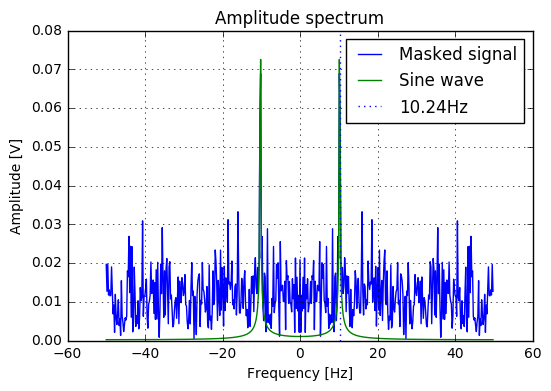

In [6]:
RN = fft(rn)/Ns
SW = fft(sw)/Ns
MS = fft(ms)/Ns
freqs = fftfreq(ms.size, d=1./Fs)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (RN, SW, MS) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(fftshift(freqs), fftshift(np.absolute(MS)), label='Masked signal')
ax.plot(fftshift(freqs), fftshift(np.absolute(SW)), label='Sine wave')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Amplitude spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V]')
ax.legend()
ax.grid(True)

Several aspects can be seen in these results:

1. The amplitude spectra are symmetric about the origin. The Fourier transform of real signals is Hermitian, resulting in a symmetrical amplitude spectrum. For this reason it is called a two-sided spectrum (more on this below).
2. The peak values of both sine wave and masked signal occur at the same frequency, but its value which does not match the sine wave 
3. The sine wave and the masked signal peak values are not exactly the same of both the  occur at are the same but the frequencies do not ... The amplitude of the normalised FFT is proportional to...:


In [7]:
print(A**2/4/np.sqrt(2))

0.00707106781187


Since the signal is real, the Fourier transform is Hermitian. For that reason, we will use the rfft function instead which gives us only the spectral components from 0Hz up to the Nyquist frequency (the first half of the two-sided spectrum):

                    Max       Freq
Random noise   0.034054  16.015625
Sine wave      0.072531  10.156250
Masked signal  0.068864  10.156250


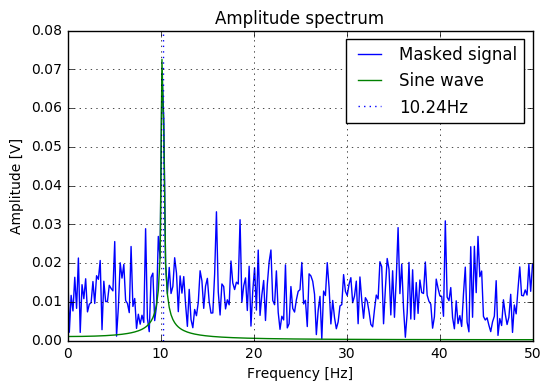

In [8]:
RN = rfft(rn)/Ns
SW = rfft(sw)/Ns
MS = rfft(ms)/Ns
freqs = rfftfreq(ms.size, d=1./Fs)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (RN, SW, MS) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, np.absolute(MS), label='Masked signal')
ax.plot(freqs, np.absolute(SW), label='Sine wave')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Amplitude spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V]')
ax.legend()
ax.grid(True)

[Back to top](#top)

## Power spectrum

The first estimation of the signal power spectrum will be achieved by mutliplying this (complex) FFT by its conjugate:

                    Max       Freq
Random noise   0.001160  16.015625
Sine wave      0.005261  10.156250
Masked signal  0.004742  10.156250


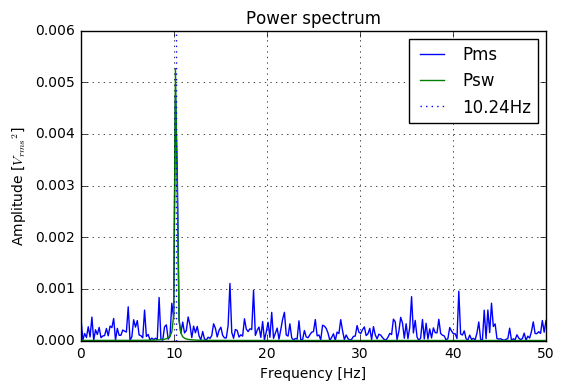

In [9]:
Prn = np.real(RN*np.conj(RN))
Psw = np.real(SW*np.conj(SW))
Pms = np.real(MS*np.conj(MS))

v = [(v[ix], freqs[ix]) for v in (Prn, Psw, Pms) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pms, label='Pms')
ax.plot(freqs, Psw, label='Psw')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2$]')
ax.legend()
ax.grid(True)

This could be achieved by using directly the periodogram function:

                    Max       Freq
Random noise   0.002319  16.015625
Sine wave      0.010522  10.156250
Masked signal  0.009485  10.156250


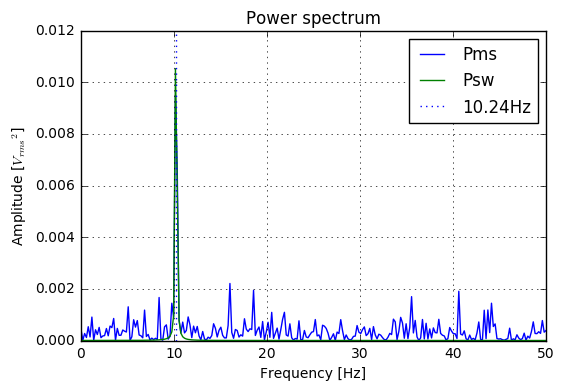

In [10]:
freqs, Prn = periodogram(rn, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')
freqs, Psw = periodogram(sw, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')
freqs, Pms = periodogram(ms, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='spectrum')

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Prn, Psw, Pms) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pms, label='Pms')
ax.plot(freqs, Psw, label='Psw')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2$]')
ax.legend()
ax.grid(True)

The peak of the Pms estimated by the periodogram function is the double of the Pms estimated through the FFT of the signal because it was computed as a one-sided spectrum instead of a two-sided spectrum as it would have been achieved using the FFT:

In [11]:
print(df['Max']['Sine wave']/2)

0.00526076689053


More important than the power spectrum is, in our case, the power spectral density of the signal:

                    Max       Freq
Random noise   0.011875  16.015625
Sine wave      0.053870  10.156250
Masked signal  0.048561  10.156250


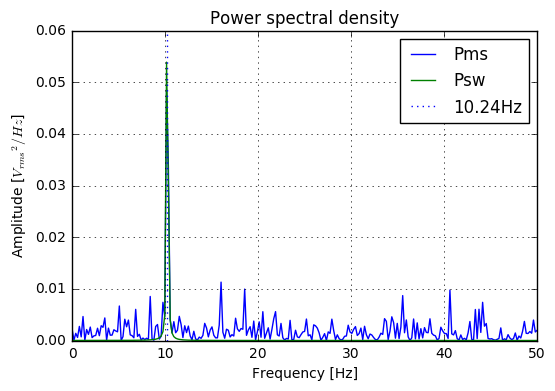

In [12]:
freqs, Prn = periodogram(rn, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')
freqs, Psw = periodogram(sw, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')
freqs, Pms = periodogram(ms, fs=Fs, window=None, nfft=None, detrend=None, return_onesided=True, scaling='density')

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Prn, Psw, Pms) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pms, label='Pms')
ax.plot(freqs, Psw, label='Psw')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [${V_{rms}}^2/Hz$]')
ax.legend()
ax.grid(True)

Naturally, the peak power spectrum can be estimated from the power spectral density by multiplying by the frequency discretisation:

In [13]:
print(df['Max']['Sine wave']/2*(freqs[1]-freqs[0]))

0.00526076689053


[Back to top](#top)

## Matplotlib package

Matplotlib supplies one function, [psd](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.psd), to estimate the power spectral density (Pxx) of a signal (x) in the [mlab](http://matplotlib.org/api/mlab_api.html) module. This function, which is described as a "Welch’s average periodogram method", has the following signature:

    matplotlib.mlab.psd(x, NFFT=256, Fs=2, detrend=mlab.detrend_none, window=mlab.window_hanning, noverlap=0, pad_to=None,sides='default', scale_by_freq=None)

The function returns a tuple with the power spectral density estimate and the corresponding frequencies (Pxx, freqs).

                    Max      Freq
Random noise   0.008181  43.75000
Sine wave      0.032052  10.15625
Masked signal  0.028819  10.15625


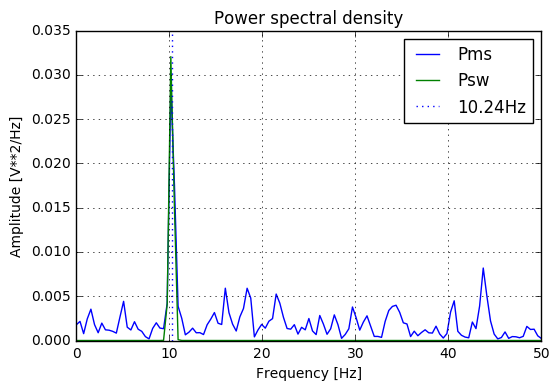

In [14]:
Prn, freqs = psd(rn, NFFT=256, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)
Psw, freqs = psd(sw, NFFT=256, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)
Pms, freqs = psd(ms, NFFT=256, Fs=Fs, detrend=detrend_none, window=window_hanning, noverlap=0, pad_to=None,
                 sides='onesided', scale_by_freq=True)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Prn, Psw, Pms) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pms, label='Pms')
ax.plot(freqs, Psw, label='Psw')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)

[Back to top](#top)

## SciPy package

SciPy supplies two functions to estimate the power spectral density (Pxx) of a signal (x) in the [signal](https://scipy.github.io/devdocs/signal.html) module, [periodogram](https://scipy.github.io/devdocs/generated/scipy.signal.periodogram.html) and [welch](https://scipy.github.io/devdocs/generated/scipy.signal.welch.html). Their signatures are the following:

    scipy.signal.periodogram(x, fs=1.0, window=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

    scipy.signal.welch(x, fs=1.0, window='hann', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

The first function uses a periodogram whereas the second function uses the Welch’s method. In the particular case that noverlap is 0, this method is equivalent to Bartlett’s method. Both functions return a tuple with the frequencies and the power spectral density estimate (freqs, Pxx).

                    Max      Freq
Random noise   0.011338  43.75000
Sine wave      0.032163  10.15625
Masked signal  0.036049  10.15625


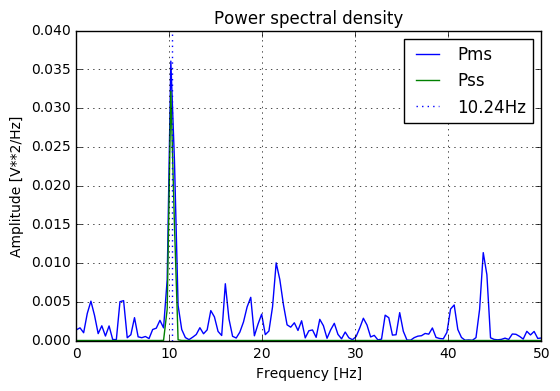

In [15]:
freqs, Prn = periodogram(rn, fs=Fs, window='hann', nfft=256, detrend=None,
                         return_onesided=True, scaling='density', axis=-1)
freqs, Psw = periodogram(sw, fs=Fs, window='hann', nfft=256, detrend=None,
                         return_onesided=True, scaling='density', axis=-1)
freqs, Pms = periodogram(ms, fs=Fs, window='hann', nfft=256, detrend=None,
                         return_onesided=True, scaling='density', axis=-1)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Prn, Psw, Pms) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pms, label='Pms')
ax.plot(freqs, Psw, label='Pss')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)

                    Max       Freq
Random noise   0.006205  18.359375
Sine wave      0.032163  10.156250
Masked signal  0.031526  10.156250


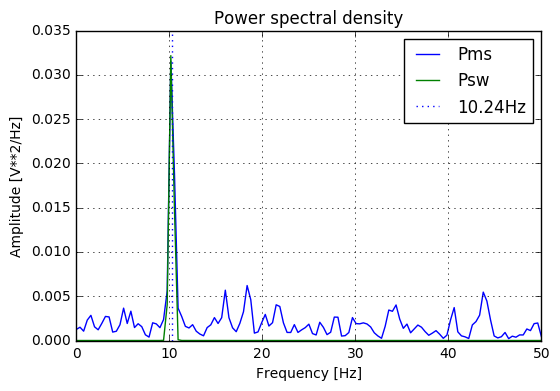

In [16]:
freqs, Prn = welch(rn, fs=Fs, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)
freqs, Psw = welch(sw, fs=Fs, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)
freqs, Pms = welch(ms, fs=Fs, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=None,
                   return_onesided=True, scaling='density', axis=-1)

v = [(np.absolute(v[ix]), freqs[ix]) for v in (Prn, Psw, Pms) for ix in (np.argmax(np.absolute(v)),)]
df = pd.DataFrame(data=v, index=('Random noise', 'Sine wave', 'Masked signal'), columns=('Max', 'Freq'))
print(df)

fig, ax = plt.subplots()
ax.hold(True)
ax.plot(freqs, Pms, label='Pms')
ax.plot(freqs, Psw, label='Psw')
ax.axvline(f, label='{}Hz'.format(f), ls=':')
ax.set_title('Power spectral density')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [V**2/Hz]')
ax.legend()
ax.grid(True)

[Back to top](#top)

## References

P. Welch, “The use of the fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms”, IEEE Trans. Audio Electroacoust. vol. 15, pp. 70-73, 1967.

[Back to top](#top)

## Odds and ends

This notebook was created by Paulo Xavier Candeias.

[Back to top](#top)